# Setup instructions

---

## Creating a virtual environment (if running locally)

1. Open the terminal in the folder where this file is and run `python -m <venv name> <path for venv folder>`
   For e.g. I ran `python -m venv .\venv` and it is important to note that the `.\venv` folder did not exist before I ran the command but I have to specify the name of the folder of venv
2. Once the virtual env folder is created, execute the command `<venv folder name>\Scripts\activate` to activate the virtual environment

## Installing requirements

In your terminal make sure that you are in this directory where this `requiurements.txt` is present and execute `pip install -r requirements.txt`

## IBM API token

Assuming that you have `python-dotenv` installed by now, if the above steps were completed without any errors, create a `.env` file in this directory and in it specify your key in the following format `IBM_API_KEY=your_long_ibm_api_key`

You can get the key by logging into your IBM account at [IBM Quantum Website](https://quantum.ibm.com/) and on the top right corner you should be able to see your api token (Refer below image)

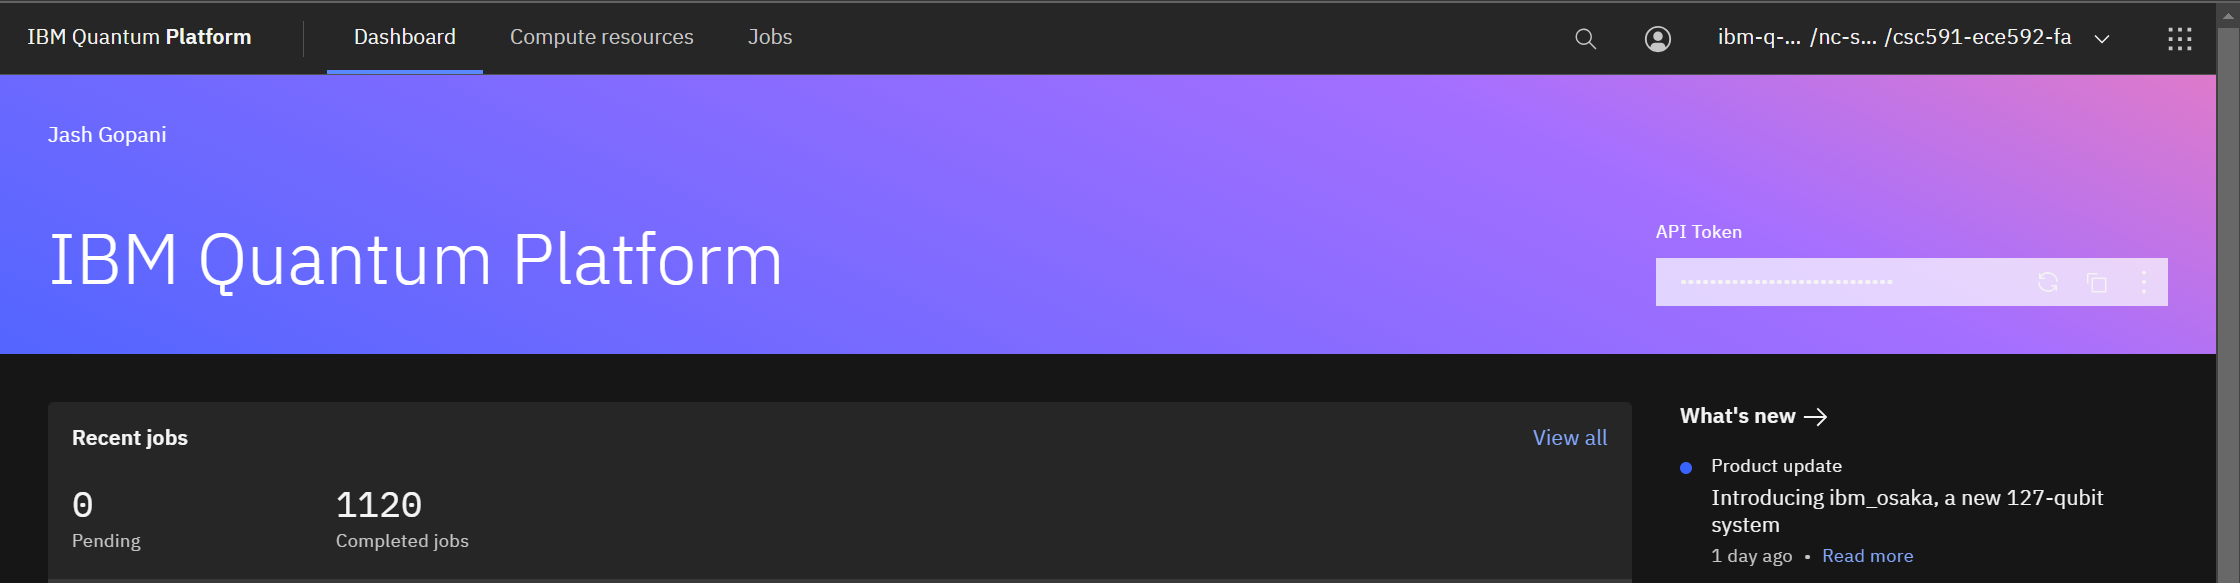


# Imports and IBM account connection setup


In [25]:
# General imports
import numpy as np
import os
import random
from dotenv import load_dotenv

# Plotting functions
import matplotlib.pyplot as plt
import networkx as nx

# SciPy minimizer routine
from scipy.optimize import minimize

# Qiskit imports
from qiskit import IBMQ, execute, Aer
from qiskit_ibm_provider import IBMProvider
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService,  Session, Options
from qiskit.primitives import Estimator
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import EfficientSU2, TwoLocal

If the below cell gives an error that account is already saved then it is fine


In [26]:
load_dotenv()
IBMProvider.save_account(os.getenv('IBM_API_KEY'))

AccountAlreadyExistsError: 'Named account (default-ibm-quantum) already exists. Set overwrite=True to overwrite.'

In [27]:
# Setup account and backend service
provider = IBMProvider()
service = QiskitRuntimeService()

# Implementation Starts here

All the methods are defined first then the graph is created and classical and quantum algorithms are executed

The code from this [Qiskit demo article](https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver) is used as a base template for this implementation

Other references

-   [https://qiskit.org/ecosystem/optimization/tutorials/06_examples_max_cut_and_tsp.html](https://qiskit.org/ecosystem/optimization/tutorials/06_examples_max_cut_and_tsp.html)


In [28]:
# Computing the weight matrix from the random graph
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600,
                     alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

In [29]:
def draw_circuit(qc: QuantumCircuit):
    qc.draw(output='mpl', style='clifford')

In [30]:
def add_hwe_ansatz(qc: QuantumCircuit, repetation_count=2) -> QuantumCircuit:
    n = qc.num_qubits
    theta, phi = Parameter('theta'), Parameter('phi')

    for _ in range(repetation_count):
        for i in range(n):
            qc.rx(theta, i)
            qc.ry(phi, i)

        for i in range(n-1):
            qc.cx(i, i+1)

In [31]:
def add_hwe_ansatz2(qc: QuantumCircuit, repetation_count=2) -> QuantumCircuit:
    n = qc.num_qubits
    theta, phi = Parameter('theta'), Parameter('phi')
    params = [[Parameter(f"param_{i}_0"), Parameter(
        f"param_{i}_1")] for i in range(n)]

    for _ in range(repetation_count):
        for i in range(n):
            qc.rx(params[i][0], i)
            qc.ry(params[i][1], i)

        for i in range(n-1):
            qc.cx(i, i+1)

In [32]:
def add_ry_ansatz(qc: QuantumCircuit, repetation_count=2) -> QuantumCircuit:
    n = qc.num_qubits
    theta = Parameter('theta')

    for i in range(n):
        qc.ry(theta, i)

In [33]:
def identity_pauli_string(n):
    return ["I" for _ in range(n)]

In [36]:
def get_pauli_strings_from_graph(sparse_graph_list, n):
    pauli_strings = []
    for (x, y, w) in sparse_graph_list:
        temp_pauli_string_arr = identity_pauli_string(n)
        temp_pauli_string_arr[x] = temp_pauli_string_arr[y] = "Z"
        pauli_strings.append("".join(temp_pauli_string_arr))

    return list(set(pauli_strings))

In [35]:
def generate_random_param_values(num_params):
    return [random.uniform(-2*np.pi, 2*np.pi) for _ in range(num_params)]

In [37]:
def cost_func(params, ansatz, hamiltonian, estimator, intermediate_data, num_params, print_debug_info=False):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Flattened Array of ansatz parameters
        ansatz (QuantumCircuit): Array of Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        intermediate_data (Dict): mutable object to store intermediate data
        num_params (int): Number of parameters in circuit
        print_debug_info (Boolean): Whether to print each iteration's information (False by default)
    Returns:
        float: Energy estimate
    """

    # perform cost calculation
    energy = sum(estimator.run(ansatz, hamiltonian,
                 parameter_values=params).result().values)

    # update data for analysis
    intermediate_data["params_history"].append(params)
    intermediate_data['iters'] += 1
    intermediate_data["cost_history"].append(energy)
    if (print_debug_info):
        print("Iters. done: {}, Params: {}, Current cost: {}".format(
            intermediate_data["iters"], params, energy))
    return energy

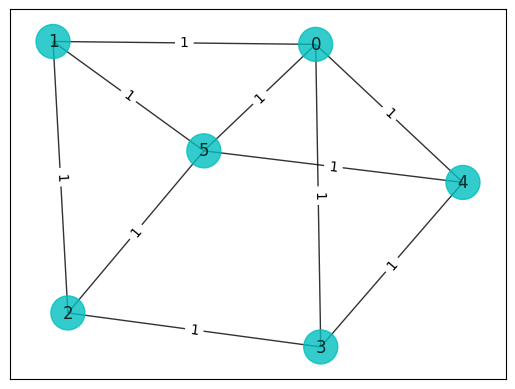

In [43]:
# Defining a graph
n = 6
list_edges = [[0, 1], [1, 2], [2, 5],
              [0, 3], [1, 5], [3, 4],
              [0, 4], [2, 3], [4, 5],
              [0, 5], [2, 5]]

elist = [(x, y, 1) for x, y in list_edges]

G = nx.Graph()
G.add_weighted_edges_from(elist)
colors = ["c" for i in range(n)]
draw_graph(G, colors, nx.spring_layout(G))
plt.show()

['IIIIZZ', 'IIIZZI', 'IIZIIZ', 'IIZZII', 'IZIIIZ', 'IZZIII', 'ZIIIIZ', 'ZIIIZI', 'ZIIZII', 'ZZIIII']
[[5.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 2.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 2.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 5.+0.j]]


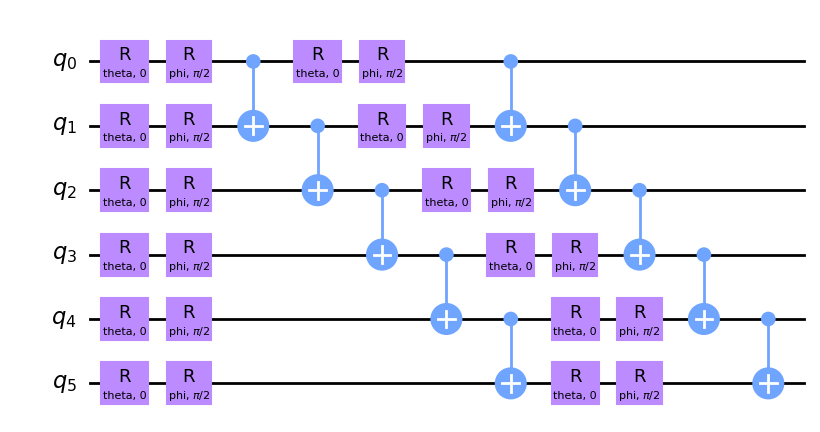

In [45]:
# For using hardware efficient ansatz, comment other two ansatz lines
ansatz_qc = QuantumCircuit(n, name='Hardware Efficient Ansatz')

add_hwe_ansatz(ansatz_qc)

# For using TwoLocal ansatz, comment other two ansatz lines
# ansatz_qc = TwoLocal(6, "ry", "cz", reps=5, entanglement="linear")

# For using EfficientSU2 ansatz, comment other two ansatz lines
# ansatz_qc = EfficientSU2(n)


ansatz_qc = ansatz_qc.decompose()

num_params = ansatz_qc.num_parameters

pauli_strings = get_pauli_strings_from_graph(elist, n)

print(pauli_strings)

# Based on cost function equation

hamiltonian_arr = SparsePauliOp.from_list([(p, 0.5) for p in pauli_strings])

ansatz_qc.draw(output='mpl', style='clifford')

num_params 48


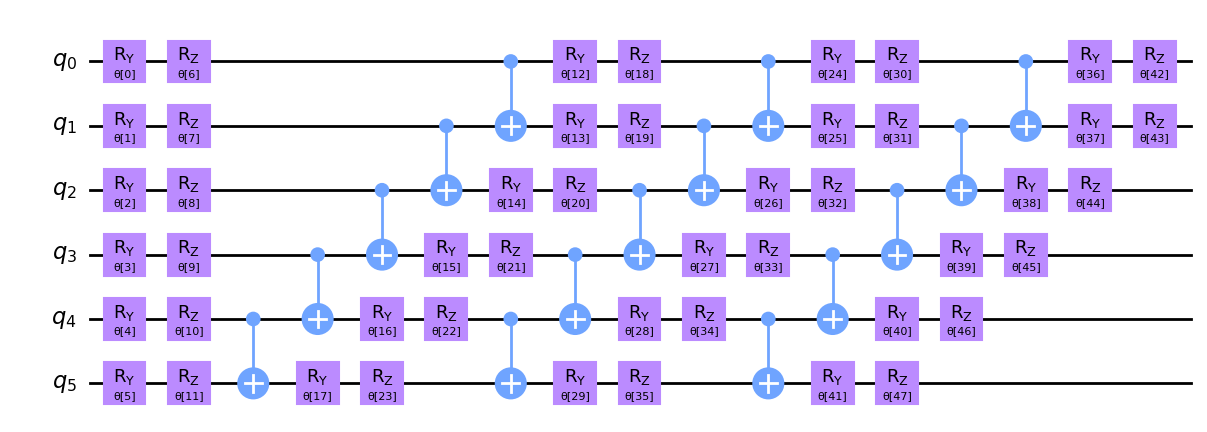

In [41]:
print('num_params', num_params)
ansatz_qc.draw(output='mpl', style='clifford')

# **Classic Brute Force Calculation**



Best solution = [1, 0, 1, 0, 1, 0] cost = 8.0


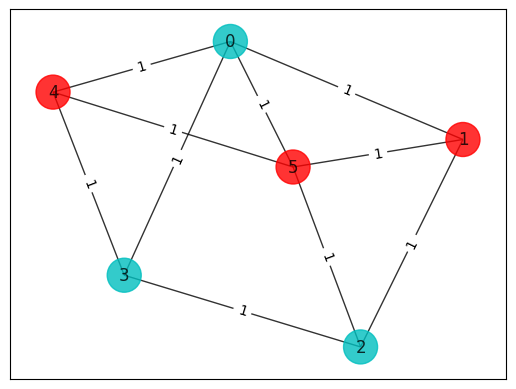

In [42]:
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]

best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    # print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, nx.spring_layout(G))
print("\nBest solution = " + str(xbest_brute) +
      " cost = " + str(best_cost_brute))

# Using **ibmq_qasm_simulator**

Run this cell to execute VQE on IBM server


In [ ]:
# Code to run on ibm-runtime-simulator
options = Options()
options.transpilation.skip_transpilation = True
options.execution.shots = 100000

intermediate_data = {
    "params_history": [],
    "iters": 0,
    "cost_history": [],
}

with Session(backend="qasm_simulator") as session:
    estimator = Estimator()
    res = minimize(
        fun=cost_func,
        x0=generate_random_param_values(num_params),
        args=(ansatz_qc, hamiltonian_arr, estimator,
              intermediate_data, num_params),
        method="cobyla",
    )

print('\nintermediate_data [#iterations: {} , cost: {}, params:{}]'.format(
    intermediate_data['iters'], intermediate_data['cost_history'][-1], intermediate_data['params_history'][-1]))
print('res', res)

# **Using Aer Simulator backend**

Alternatively run this cell to run the algorithm locally


In [47]:
from qiskit import Aer, QuantumCircuit, transpile, assemble
from qiskit_aer.primitives import Estimator as AerEstimator

intermediate_data = {
    "params_history": [],
    "iters": 0,
    "cost_history": [],
}
# print(hamiltonian_arr)


with Session(backend=Aer.get_backend('aer_simulator')) as session:
    estimator = AerEstimator(run_options={'shots': 100000})
    res = minimize(
        fun=cost_func,
        x0=generate_random_param_values(num_params),
        args=(ansatz_qc, hamiltonian_arr, estimator,
              intermediate_data, num_params, True),
        method="cobyla",
    )

print('\nintermediate_data [#iterations: {} , cost: {}, params:{}]'.format(
    intermediate_data['iters'], intermediate_data['cost_history'][-1], intermediate_data['params_history'][-1]))
print('res', res)

Iters. done: 1, Params: [4.92743112 2.7353827 ], Current cost: 3.9781
Iters. done: 2, Params: [5.92743112 2.7353827 ], Current cost: 0.37054999999999993
Iters. done: 3, Params: [5.92743112 3.7353827 ], Current cost: 0.28575
Iters. done: 4, Params: [6.92715496 3.75888246], Current cost: 0.13604000000000002
Iters. done: 5, Params: [7.36081198 4.00776313], Current cost: -0.11740999999999988
Iters. done: 6, Params: [7.44274248 4.50100485], Current cost: 0.09658
Iters. done: 7, Params: [7.78251523 3.73912514], Current cost: -0.53819
Iters. done: 8, Params: [8.16704816 3.41954036], Current cost: -0.7970300000000001
Iters. done: 9, Params: [8.14894243 2.91986829], Current cost: -0.8332500000000002
Iters. done: 10, Params: [8.64281058 2.84180261], Current cost: 0.15068000000000004
Iters. done: 11, Params: [7.89894243 2.91983131], Current cost: -0.9253899999999999
Iters. done: 12, Params: [7.65209951 2.88022607], Current cost: -0.87311
Iters. done: 13, Params: [7.89896092 2.79483131], Current c

# Using final parameters to get the state vector

Irrespective of whether you ran the VQE on IBM server or locally, the below cells would help you visualize the results


optimal parameters [7.86401466 3.13833937]


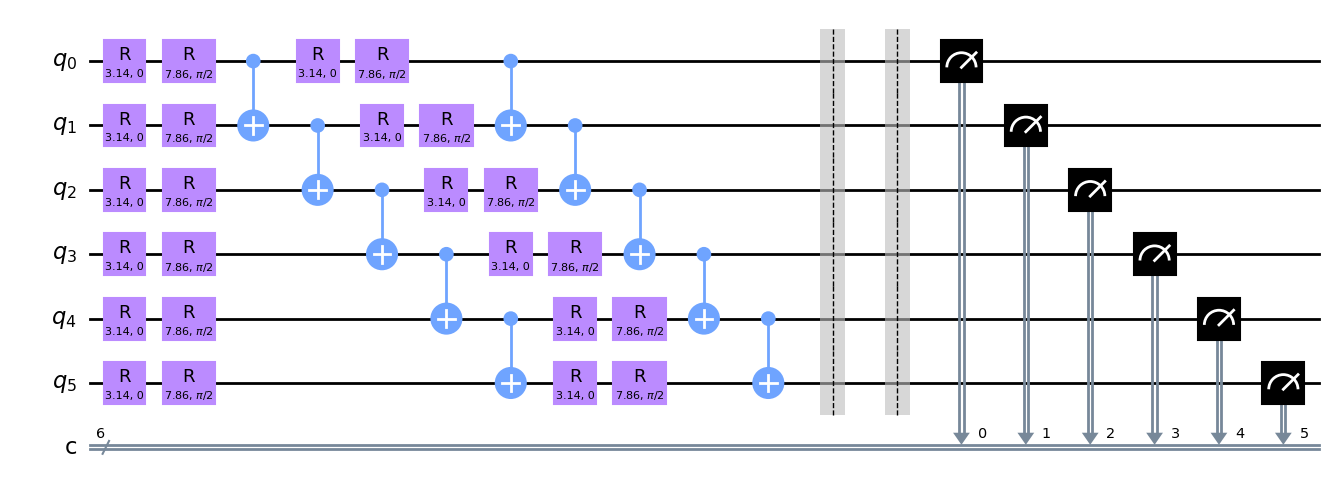

In [48]:
# Use Aer simulator backend
from qiskit.visualization import plot_state_city
aer_backend = Aer.get_backend('aer_simulator')


print('optimal parameters', intermediate_data['params_history'][-1])

# Transpile the circuit for the simulator
t_ansatz_qc = QuantumCircuit(n, n)
t_ansatz_qc.compose(ansatz_qc, inplace=True)
t_ansatz_qc = t_ansatz_qc.assign_parameters(
    intermediate_data['params_history'][-1])
t_ansatz_qc.barrier()
t_ansatz_qc.measure_all(add_bits=False)


backend = service.get_backend('simulator_mps')
result = aer_backend.run(t_ansatz_qc, shots=10000).result()

# Get the final state
final_state = result.get_counts()

t_ansatz_qc.draw(output='mpl', style='clifford')

{'110101': 9995, '100101': 1, '110001': 1, '001010': 2, '001101': 1}


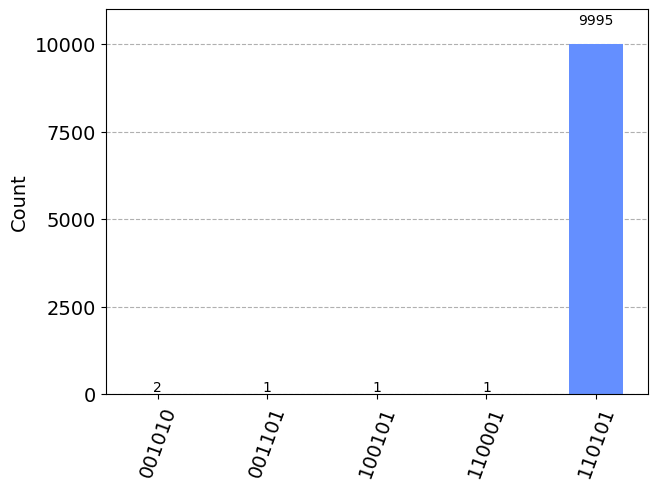

In [49]:
print(final_state)
plot_histogram(final_state)

# Visualizing Parameters and convergence

We can also now view the progress towards convergence as monitored by the cost history at each iteration:


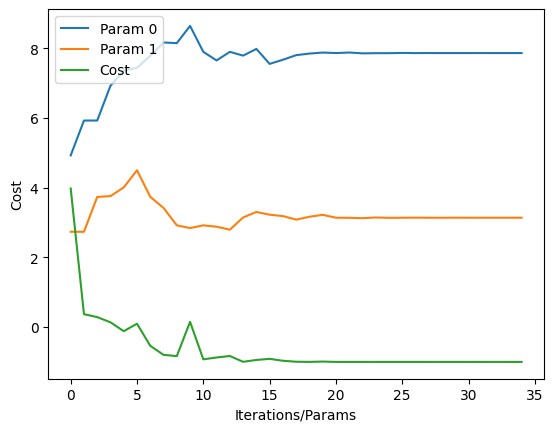

In [52]:
fig, ax = plt.subplots()
# Extracting parameter value history from the 2D array using zip(*two_d_array)
transposed_array = list(zip(*intermediate_data['params_history']))
column_lists = [list(column) for column in transposed_array]

# Comment out this for loop for very large number of parameters since graph becomes very messy
for i, p in enumerate(column_lists):
    ax.plot(p, label='Param {}'.format(i))

ax.plot(range(intermediate_data['iters']),
        intermediate_data['cost_history'], label='Cost')
ax.set_xlabel("Iterations/Params")
ax.set_ylabel("Cost")

plt.legend()
plt.draw()